In [1]:
import pandas as pd 

# reading in pavement data
p_full = pd.read_csv('pavement_ratings.csv')

In [ ]:
# filtering for necessary yrs and cols

p = p_full[
    ['the_geom', 'SegmentID', 'Rating_B', 'RatingFY_S']
].loc[p_full['RatingFY_S'].isin([2017, 2018, 2019, 2021, 2022, 2023])]

p.head()

,the_geom,SegmentID,Rating_B,RatingFY_S
5,MULTILINESTRING ((-74.1996796165617 40.5185180...,1086,9,2018
7,MULTILINESTRING ((-74.19756704522862 40.520503...,1135,8,2021
8,MULTILINESTRING ((-74.19521548161397 40.518289...,1150,7,2019
10,MULTILINESTRING ((-74.23051685807188 40.545455...,1184,8,2021
16,MULTILINESTRING ((-74.2220446196335 40.5328653...,1283,9,2018


In [3]:
from shapely.wkt import loads as wkt_loads

# converting to correct data type

p['the_geom'] = p['the_geom'].apply(wkt_loads)

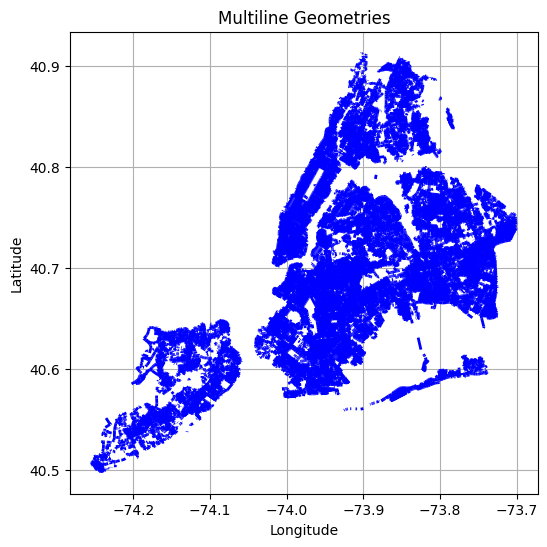

In [4]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# plotting pavement data

gdf = gpd.GeoDataFrame(p, geometry='the_geom', crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 6))
gdf.plot(ax=ax, color='blue', linewidth=2)

plt.title('Multiline Geometries')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [5]:
# reading and filtering school location data

schools = pd.read_csv('school_locs.csv')
schools = schools[['location_code', 'location_name', 'LONGITUDE', 'LATITUDE', 'Police_precinct']]
schools = schools[schools['LONGITUDE'] != 0]
schools.head()

,location_code,location_name,LONGITUDE,LATITUDE,Police_precinct
0,K001,P.S. 001 The Bergen,-74.011420,40.648959,72.0
1,K002,Parkside Preparatory Academy,-73.951575,40.656423,71.0
2,K003,P.S. 003 The Bedford Village,-73.955219,40.682311,79.0
3,K004,P.S. K004,-73.879276,40.658500,75.0
4,K005,P.S. 005 Dr. Ronald McNair,-73.921970,40.685241,81.0


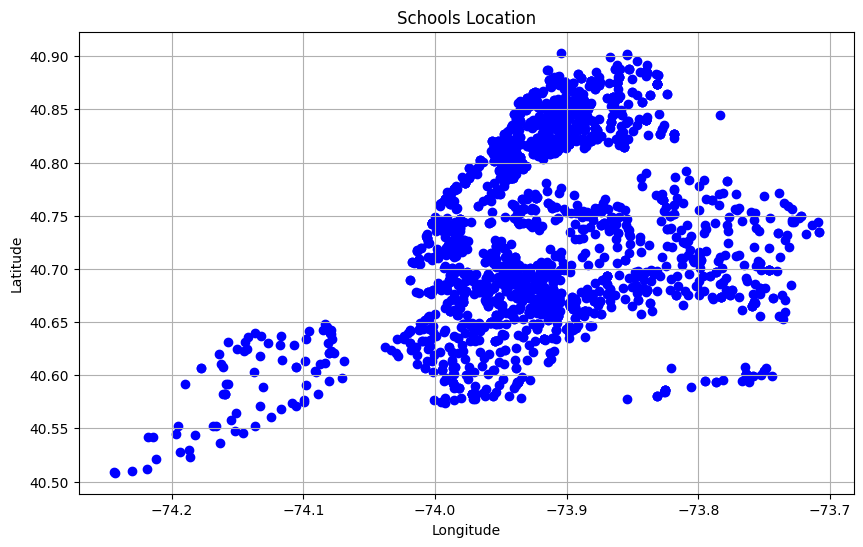

In [9]:
import matplotlib.pyplot as plt

# plotting school location data

plt.figure(figsize=(10, 6))
plt.scatter(schools['LONGITUDE'], schools['LATITUDE'], color='blue', marker='o')

plt.title('Schools Location')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()

In [28]:
import geopandas as gpd
import pandas as pd

filtered_p = p[p['RatingFY_S'] == 2017]
valid_geometries = filtered_p['the_geom'].notna() & filtered_p['the_geom'].apply(lambda x: 'MULTILINESTRING' in x.wkt)

pavement_gdf = gpd.GeoDataFrame(
    filtered_p[valid_geometries],
    geometry=filtered_p.loc[valid_geometries, 'the_geom'],
    crs='EPSG:4326'
)

schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=gpd.points_from_xy(schools['LONGITUDE'], schools['LATITUDE']),
    crs='EPSG:4326'
)

schools_gdf = schools_gdf.to_crs('EPSG:3857')
schools_gdf['geometry'] = schools_gdf.geometry.buffer(1600)

pavement_gdf = pavement_gdf.to_crs('EPSG:3857')
joined_gdf = gpd.sjoin(schools_gdf, pavement_gdf, how='left', predicate='intersects')

In [33]:
average_ratings = (joined_gdf.groupby(['location_code', 'location_name'])
                   .agg({'Rating_B': 'mean'})
                   .rename(columns={'Rating_B': 'average_rating'})
                   .reset_index())

schools_with_ratings = schools_gdf.merge(average_ratings, on=['location_code', 'location_name'], how='left')

print(schools_with_ratings[['location_code', 'location_name', 'average_rating']])


     location_code                            location_name  average_rating
0             K001                      P.S. 001 The Bergen        6.833333
1             K002             Parkside Preparatory Academy        8.000000
2             K003             P.S. 003 The Bedford Village        6.000000
3             K004                                P.S. K004        6.800000
4             K005               P.S. 005 Dr. Ronald McNair        8.000000
...            ...                                      ...             ...
2180          X729             Readnet Bronx Charter School        7.500000
2181          X730        Bronx Charter School for the Arts        7.545455
2182          X754  J. M. Rapport School Career Development        7.750000
2183          X811                                P.S. X811        7.272727
2184          X811                                P.S. X811        7.272727

[2185 rows x 3 columns]


In [32]:
grouped_ratings = joined_gdf.groupby('location_code')['Rating_B'].unique().reset_index()
print(grouped_ratings)

     location_code              Rating_B
0             K001       [7.0, 8.0, 6.0]
1             K002                 [8.0]
2             K003                 [6.0]
3             K004  [5.0, 9.0, 7.0, 6.0]
4             K005                 [8.0]
...            ...                   ...
2121          X723            [8.0, 7.0]
2122          X729            [7.0, 8.0]
2123          X730  [8.0, 7.0, 9.0, 6.0]
2124          X754            [7.0, 8.0]
2125          X811  [7.0, 9.0, 8.0, 6.0]

[2126 rows x 2 columns]


In [ ]:
import geopandas as gpd

def get_schools_with_ratings(filtered_p, schools, year):
    
    # deletes any bad data
    valid_geometries = filtered_p['the_geom'].notna() & filtered_p['the_geom'].apply(lambda x: 'MULTILINESTRING' in x.wkt)

    # converting both dfs to geometric data type
    pavement_gdf = gpd.GeoDataFrame(
        filtered_p[valid_geometries],
        geometry=filtered_p.loc[valid_geometries, 'the_geom'],
        crs='EPSG:4326'
    )

    schools_gdf = gpd.GeoDataFrame(
        schools,
        geometry=gpd.points_from_xy(schools['LONGITUDE'], schools['LATITUDE']),
        crs='EPSG:4326'
    )

    schools_gdf = schools_gdf.to_crs('EPSG:3857')

    # adding buffer -- includes streets within 1 mile of schools
    schools_gdf['geometry'] = schools_gdf.geometry.buffer(1600)

    pavement_gdf = pavement_gdf.to_crs('EPSG:3857')

    # merges our data and finds avg ratings
    joined_gdf = gpd.sjoin(schools_gdf, pavement_gdf, how='left', predicate='intersects')

    average_ratings = (joined_gdf.groupby(['location_code', 'location_name'])
                       .agg({'Rating_B': 'mean'})
                       .rename(columns={'Rating_B': 'average_rating'})
                       .reset_index())

    schools_with_ratings = schools_gdf.merge(average_ratings, on=['location_code', 'location_name'], how='left')

    # add time component
    schools_with_ratings['year'] = year 

    # validation check
    schools_with_ratings.head()

    return schools_with_ratings[['location_code', 'location_name', 'average_rating']]


In [ ]:
merged_2017 = get_schools_with_ratings(p[p['RatingFY_S'] == 2017], schools, 2017)
merged_2018 = get_schools_with_ratings(p[p['RatingFY_S'] == 2018], schools, 2018)
merged_2019 = get_schools_with_ratings(p[p['RatingFY_S'] == 2019], schools, 2019)
merged_2021 = get_schools_with_ratings(p[p['RatingFY_S'] == 2021], schools, 2021)
merged_2022 = get_schools_with_ratings(p[p['RatingFY_S'] == 2022], schools, 2022)
merged_2023 = get_schools_with_ratings(p[p['RatingFY_S'] == 2023], schools, 2023)